In [1]:
import numpy as np
import matplotlib
#%matplotlib notebook
matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt
from scipy import integrate, interpolate, signal, optimize, stats

import cPickle as pickle
from sklearn.utils import shuffle

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization, Flatten
from keras.optimizers import Nadam, SGD
from keras.callbacks import ModelCheckpoint


np.set_printoptions(edgeitems=30, linewidth=160)
#edgeitems: Number of array items in summary at beginning and end of each dimension (default 3).
#linewidth : The number of characters per line for the purpose of inserting line breaks (default 75).

Using TensorFlow backend.


In [2]:
# This Part of The Code Reads The Noise Curve Files For The Selected Detectors  
#help(lal.ArrivalTimeDiff)
def ASDtxt(x):
    return {
        'LET':'./ASD/ET_D.txt',
        'LCE':'./ASD/CE.txt',
        'H1': './ASD/ligoII_NS.txt',
        'L1': './ASD/ligoII_NS.txt',
        'V1': './ASD/virgoII.txt',
        'I2': './ASD/ligoII_NS.txt',
        'KAGRA': './ASD/ligoII_NS.txt',
        'ET_1': './ASD/ET_D.txt',
        'ET_2': './ASD/ET_D.txt',
        'ET_3': './ASD/ET_D.txt',
        'A2': './ASD/ligoII_NS.txt',
        'A2.5': './ASD/ligoII_NS.txt',
    }[x]


In [3]:
# reading the noise curves.
def readnos(detector, f_points):
    nos_file = ASDtxt(detector)
    f_str = []
    ASD_str = []
    file = open(nos_file, 'r')
    readFile = file.readlines()
    file.close()
    f = []
    ASD = []
    
    for line in readFile:
        p = line.split()
        f_str.append(float(p[0]))
        ASD_str.append(float(p[1]))
    f = np.log10(np.array(f_str))
    ASD = np.log10(np.array(ASD_str))
    nosinterpolate = interpolate.splrep(f, ASD, w=1.0*np.ones(len(ASD)), s=0)
    
    nos = interpolate.splev(np.log10(f_points), nosinterpolate, der = 0, ext = 3)
    nos = 10**nos
    
    return nos

In [4]:
def simsinsignal(t_samples, NO_sin, A_low, A_high, f_low, f_high, phase_low, phase_high, index):
    
    
    
    Amplitudes = np.random.uniform(A_low, A_high, NO_sin)
    Frequencies = np.random.uniform(f_low, f_high, NO_sin)
    Phases = np.random.uniform(phase_low, phase_high, NO_sin)
    
    if index == 0:
        msg = 'Each signal generated will contain %s simple sinusoidal signal components.' %(NO_sin) 
        print(msg)
        msg = 'The amplitudes are as follows:'
        print(msg)
        print(Amplitudes[0])
        msg = 'The frequencies are as follows:'
        print(msg)
        print(Frequencies[0])
        msg = 'The phases are as follows:'
        print(msg)
        print(Phases[0])
        print('\n')
    
    signal = np.zeros_like(t_samples)
    
    for i in range(NO_sin):
        signal += Amplitudes[i] * np.sin(2.0 * np.pi * Frequencies[i] * t_samples + Phases[i])
    return signal

In [5]:
def noisegenerator(Tobs, det, SR, df, dt, ASD):
    Ns = Tobs * SR
    Nf = int(np.ceil(Ns /2) + 1)
    
    Amp = ASD
    
    real_nos = Amp * np.random.normal(0.0, 1.0, Nf)
    img_nos = Amp * np.random.normal(0.0, 1.0, Nf)
    
    nos = real_nos + 1j * img_nos
    
    idx_1 = int(20 // df)
    nos[0:idx_1] = 0
    
    
    
    nos_realization = np.fft.irfft(nos) * df
    
    return nos_realization
    

In [6]:
#whole signal length always longer than the signal itself so that the signal can shift
def shift_signal(nos_realization, SD, shift_percent, signal, shift_applied):
    
    Tobs_mid = len(nos_realization) // 2 + 1
    
    signal_mid = SD / 2
    
    signal_len = len(signal)
    
    
    max_shift_allowed = Tobs * shift_percent
    if shift_applied == True:
        actual_shift = np.random.uniform(Tobs_mid - max_shift_allowed, max_shift_allowed + Tobs_mid) - signal_mid
    else:
        actual_shift = Tobs_mid - signal_mid
        
    
    shifted_signal = nos_realization
    
    shifted_signal[actual_shift : actual_shift + signal_len] += signal
    
    return shifted_signal


In [55]:
def signal_generator(NO_sin, No_signals, No_realizations, shift_applied, usingASD, Detectors, SR, Tobs, 
                     SD, seed, shift_percent, A_low, A_high, f_low, f_high, phase_low, phase_high):
    
    np.random.seed(seed)
    msg = 'This generator uses seed = %s for random number generator in python.' % (seed)
    print(msg)
    
    total_number_of_time_series = int(No_signals * No_realizations * 2)
    msg = 'The No. of different signals in the data will be %s.' %(No_signals)
    print(msg)

    msg = 'The No. of nosie realizations is %s, of which the first %s will be mixed with signals later.' %(total_number_of_time_series , No_signals * No_realizations)
    print(msg)
    
    N = Tobs * SR
    dt = 1.0 / SR
    ts = np.arange(int(N)) * dt
    df = 1.0 / ts[-1]
    
    Nf = int(N//2) + 1
    fs = np.arange(Nf) * df
    
  
    
    
    msg = 'The total observation time is %s seconds, while the signal duration is %s seconds.' %(Tobs, SD)
    print(msg)
    
    
    msg = 'The No. of samples in the time domain is equal to round(%s) = %s. This means delta_t is %s seconds.' %(N, int(N), dt)
    print(msg)
    
    msg = 'So the No. of samples in the frequency domain is equal to %s, with delta_f equal to %s Hz. The maximum frequency is %s Hz.' %(Nf, df, fs[-1])
    print(msg)
    
    NW = len(Detectors)
    
    
    ASDs = np.array([np.zeros_like(fs) for i in range(NW)])
    
    nos_realizations = np.array([[np.zeros_like(ts) for i in range(total_number_of_time_series)] for j in range(NW)]) 
    SNR = np.zeros(total_number_of_time_series)
    
    """This part is for signal"""
    N_signal = SD * SR
    t_signal = np.arange(int(N_signal)) * dt
    
    
    msg = 'The No. of samples in the time domain containing the signal is %s.' %(N_signal)
    print(msg)
    
    signals = np.array([np.zeros_like(t_signal) for i in range(No_signals)])
    
    simulated_data = np.array([np.zeros_like(ts) for i in range(total_number_of_time_series)])

    print('\n')
    msg = 'Generating noise realizations............'
    print(msg)
    print(total_number_of_time_series)
    for i in range(NW):
        ASDs[i] = readnos(Detectors[i], fs)
        
        if usingASD == True:
            for j in range(total_number_of_time_series):
                nos_realizations[i, j] = noisegenerator(Tobs, Detectors[i], SR, df, dt, ASDs[i])
        else:
            nos_realizations[i, j] = np.zeros_like(ts)
            
    msg = '%s noise realizations have been generated.' %(nos_realizations.shape[0] * nos_realizations.shape[1])
    print(msg)
    print('\n')
    msg = 'Generating signals..........'
    print(msg)
    
    
    for i in range(No_signals):
     
        
        signals[i] = simsinsignal(ts, NO_sin, A_low, A_high, f_low, f_high, phase_low, phase_high, i)

        for j in range(No_realizations):
            count = i * No_realizations + j
            if Tobs > SD:
                simulated_data[count] = shift_signal(nos_realization[0, j], SD, shift_percent, signals[i],  shift_applied)
            else:
                temporary = nos_realizations[0, j] + signals[i]

                temporary = np.fft.rfft(temporary) * dt
                SNR[count] = np.sqrt(4.0 * sum(abs(temporary) ** 2 / ASDs[0] **2  * df))
                temporary = temporary / ASDs[0]
                
                temporary = np.fft.irfft(temporary) * df
                simulated_data[count] = temporary 
   
    msg = '%s signals have been generated, of which the first %s should contain signals.' %(simulated_data.shape[0], No_realizations * No_signals)
    print(msg)

    for i in range(No_signals * No_realizations,  No_signals * No_realizations * 2):       
        temporary = np.fft.rfft(nos_realizations[0,i]) * dt 
        SNR[i] = np.sqrt(4.0 * sum(abs(temporary) ** 2 / ASDs[0] **2  * df))
        temporary = temporary / ASDs[0]
        temporary = np.fft.irfft(temporary) * df 
        simulated_data[i] = temporary
    
    
    return simulated_data, ts, signals, nos_realizations, ASDs, SNR
                
            
    
    
    
    
    

In [56]:
# set random number generator


#sampling rate, in Hz
SR = 4096
#Time series duration and signal duration, in seconds
Tobs = 0.25
SD = 0.25

NO_sin = 1
No_signals = 20
No_realizations = 250
shift_applied = False
shift_percent = 0
usingASD = True
Detectors = ['H1']

A_low = 2.0e-23
A_high = 2.0e-23
f_low =300.0
f_high = 300.030
phase_low = 0.0
phase_high = 0.0
seed = 7
simulated_data, ts, signals, nos_realizations, ASD, SNR= signal_generator(NO_sin, No_signals, No_realizations, shift_applied, usingASD, Detectors, SR, Tobs, 
                     SD, seed, shift_percent, A_low, A_high, f_low, f_high, phase_low, phase_high)

simulated_label = np.zeros(No_signals * No_realizations * 2)
simulated_label[0:No_signals * No_realizations] = 1



This generator uses seed = 7 for random number generator in python.
The No. of different signals in the data will be 20.
The No. of nosie realizations is 10000, of which the first 5000 will be mixed with signals later.
The total observation time is 0.25 seconds, while the signal duration is 0.25 seconds.
The No. of samples in the time domain is equal to round(1024.0) = 1024. This means delta_t is 0.000244140625 seconds.
So the No. of samples in the frequency domain is equal to 513, with delta_f equal to 4.0039100684261975 Hz. The maximum frequency is 2050.001955034213 Hz.
The No. of samples in the time domain containing the signal is 1024.0.


Generating noise realizations............
10000


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


10000 noise realizations have been generated.


Generating signals..........
Each signal generated will contain 1 simple sinusoidal signal components.
The amplitudes are as follows:
2e-23
The frequencies are as follows:
300.0012148969859
The phases are as follows:
0.0


10000 signals have been generated, of which the first 5000 should contain signals.


In [57]:
train_signal = simulated_data
train_label = simulated_label


In [350]:
N = Tobs * SR
dt = 1.0 / SR
fontsize = 22
ts = np.arange(int(N)) * dt

plt.plot(ts, signals[0], linewidth = 2, color = 'b', label = 'Simple sin wave')
plt.xlim([-0.025, 0.275])
plt.xlabel('Time (s)', fontsize = fontsize)
plt.ylabel('Strain', fontsize =fontsize)
plt.legend(fontsize = fontsize)
plt.grid()

plt.show()

ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('normal')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('normal')
text = ax.yaxis.get_offset_text()
text.set_size(fontsize)

In [361]:
plt.plot(ts, train_signal[0], linewidth = 2, color = 'b', label = r'The inverse fft of the sin wave in the frequency domain. SNR $\simeq 2.8$')
plt.plot(ts, train_signal[5000], linewidth = 2, color = 'r', label = r'The inverse fft of a noise realization')

fontsize = 22
plt.xlabel('Time (s)', fontsize = fontsize)
plt.ylabel('Strain', fontsize =fontsize)


plt.grid(which = 'both')

ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('normal')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('normal')
text = ax.yaxis.get_offset_text()
text.set_size(fontsize)
plt.legend(fontsize = fontsize, loc = 'upper right')
plt.show()



In [360]:
plt.plot(fs, abs(temporary), )
plt.plot(fs, ASDs[0], linewidth = 2, color = 'r', label = 'Amplitude Spectral Density (aLIGO)')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('frequency (Hz)', fontsize = fontsize)
plt.ylabel('Strain', fontsize =fontsize)
plt.grid(which = 'both')



ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('normal')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('normal')
text = ax.yaxis.get_offset_text()
text.set_size(fontsize)
plt.legend(fontsize = fontsize, loc = 'upper right')
plt.show()

dsfds
                
#plt.plot(train_signal[0])

plt.show()

NameError: name 'fs' is not defined

In [58]:
test_signal = simulated_data
test_label = simulated_label

In [59]:
val_signal = simulated_data
val_label = simulated_label

In [60]:
def shuffle_data(train_signal, train_label, val_signal, val_label, test_signal, test_label,  shuffle_times):
    
    for i in range(shuffle_times):
        state = np.random.randint(0,100)
        train_signal, train_label = shuffle(train_signal, train_label, random_state=state)

        state = np.random.randint(0,100)
        test_signal, test_label = shuffle(test_signal, test_label, random_state=state)

        state = np.random.randint(0,100)
        val_signal, val_label = shuffle(val_signal, val_label, random_state=state)

    return train_signal, train_label, val_signal, val_label, test_signal, test_label

In [61]:
shuffle_times = 10
train_signal, train_label, val_signal, val_label, test_signal, test_label = shuffle_data(train_signal, train_label, val_signal, val_label, test_signal, test_label,  shuffle_times)

In [62]:
i = 16
plt.plot(ts,train_signal[i])
print(train_label[i])


plt.plot(ts, test_signal[i])
print(test_label[i])

plt.plot(ts, val_signal[i])
print(val_label[i])

plt.show()

1.0
1.0
0.0


In [245]:
pathandname = "./Data/data.pkl"
fp = open(pathandname,"w")
pickle.dump([train_signal, train_label, val_signal, val_label, test_signal, test_label, ts], fp)
fp.close()

In [9]:
with open('./Data/data.pkl') as f:
    train_signal, train_label, val_signal, val_label, test_signal, test_label, ts = pickle.load(f)

In [19]:
checksignal(train_signal, train_label, False)

In [38]:
def checksignal(signal, label, reshaped):
    iteration = signal.shape[0]
    if reshaped == False:
        zeros_check = np.zeros_like(signal[0])
        for i in range(iteration):
            if (np.array_equal(zeros_check, signal[i])) == True and label[i] != 0:
                print(i)
            elif (np.array_equal(zeros_check, signal[i])) == False and label[i] == 0:
                print(i)
                                
    
    elif reshaped == True:
        zeros_check = np.zeros_like(signal[0][0])
        for i in range(iteration):
            
            if (np.array_equal(zeros_check, signal[i][0])) == True and (np.array_equal(label[i], np.array([1, 0]))) == False:
                print(i)
            elif (np.array_equal(zeros_check, signal[i][0])) == False and (np.array_equal(label[i], np.array([1, 0]))) == True:
                print(i)

                                
    
    
    

In [63]:
"""Below is the CNN part of this code""" 

batch_size = 30      # number of time series per batch
num_classes = 2      # signal or background
epochs = 20          # number of full passes of the dataset
outdir = './results' # directory to store results in



In [64]:
length = len(train_signal)
signal_len = len(train_signal[0])

train_signal = train_signal.reshape(length,1, signal_len)
test_signal = test_signal.reshape(length,1, signal_len)
val_signal = val_signal.reshape(length,1, signal_len)

In [62]:
i = 4
plt.plot(train_signal[i][0])
print(train_label[i])
plt.show()

0.0


In [65]:
keras.backend.set_image_data_format('channels_first')
signal_len = len(train_signal[0][0])

train_signal = train_signal.reshape(-1, 1, 1, signal_len)
val_signal = val_signal.reshape(-1, 1, 1, signal_len)
test_signal = test_signal.reshape(-1, 1, 1, signal_len)

input_shape = train_signal.shape[1:]

In [66]:
train_label = keras.utils.to_categorical(train_label , num_classes)
val_label = keras.utils.to_categorical(val_label, num_classes)
test_label = keras.utils.to_categorical(test_label, num_classes)

In [150]:
5.0*1024

5120.0

In [43]:
del model

In [67]:
model = Sequential()    # define the type of keras model

# add the layers
# conv1
model.add(Conv2D(16, (1,64), activation='elu', input_shape=input_shape))
# maxpool2
model.add(MaxPool2D((1,4)))


model.add(Conv2D(16, (1,16), activation='elu'))
# maxpool2
model.add(MaxPool2D((1,4)))


# the input the fully connected layer must be 1-D vector
model.add(Flatten())
model.add(Dense(32, activation='elu'))
model.add(Dropout(0.5))
# add the output layer with softmax actiavtion for classication
model.add(Dense(num_classes, activation='softmax'))
# print a summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 16, 1, 961)        1040      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 1, 240)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 1, 225)        4112      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 1, 56)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 896)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                28704     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
__________

In [88]:
model = Sequential()    # define the type of keras model

# add the layers
# conv1
model.add(Conv2D(8, (1,64), activation='elu', input_shape=input_shape))
# maxpool2
model.add(MaxPool2D((1,8)))
# conv2
model.add(Conv2D(16, (1,16), activation='elu'))
# maxpool2
model.add(MaxPool2D((1,6)))
# the input the fully connected layer must be 1-D vector
model.add(Flatten())
model.add(Dense(32, activation='elu'))
model.add(Dropout(0.5))
# add the output layer with softmax actiavtion for classication
model.add(Dense(num_classes, activation='softmax'))
# print a summary
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 8, 1, 961)         520       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 1, 120)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 1, 105)        2064      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 1, 17)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 272)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                8736      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
__________

In [68]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr = 0.1),
              metrics=['accuracy'])


In [69]:

modelCheck = ModelCheckpoint('{0}/best_weights.hdf5'.format(outdir), monitor='val_acc', verbose=0, 
                save_best_only=True,save_weights_only=True, mode='auto', period=0)


In [70]:
history = model.fit(train_signal, train_label,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(val_signal, val_label),
                    callbacks = [modelCheck]
                   )

Train on 10000 samples, validate on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 2s 246us/step - loss: 0.5234 - acc: 0.6773 - val_loss: 0.0065 - val_acc: 1.0000
Epoch 2/20
10000/10000 [==============================] - 2s 220us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 2.8644e-04 - val_acc: 1.0000
Epoch 3/20
10000/10000 [==============================] - 2s 216us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 1.0303e-04 - val_acc: 1.0000
Epoch 4/20
10000/10000 [==============================] - 2s 215us/step - loss: 6.8878e-04 - acc: 1.0000 - val_loss: 4.7736e-05 - val_acc: 1.0000
Epoch 5/20
10000/10000 [==============================] - 2s 223us/step - loss: 4.8201e-04 - acc: 1.0000 - val_loss: 2.8308e-05 - val_acc: 1.0000
Epoch 6/20
10000/10000 [==============================] - 2s 221us/step - loss: 3.6795e-04 - acc: 1.0000 - val_loss: 1.8900e-05 - val_acc: 1.0000
Epoch 7/20
10000/10000 [==============================] - 2s 226us/step - loss: 3.5598e-04

In [71]:
# load the best model
model.load_weights('{0}/best_weights.hdf5'.format(outdir))
# evaluate
eval_results = model.evaluate(test_signal, test_label,
                              sample_weight=None,
                              batch_size=batch_size, verbose=1)
print('Test loss:', eval_results[0])
print('Test accuracy:', eval_results[1])
signal_preds = model.predict(test_signal)


10000/10000 [==============================] - 1s 72us/step
('Test loss:', 0.006506993394810707)
('Test accuracy:', 1.0)


In [72]:
signal_preds = model.predict(test_signal)
print(signal_preds)

[[0.00696066 0.9930393 ]
 [0.9937889  0.00621109]
 [0.00678684 0.9932132 ]
 [0.0065595  0.99344057]
 [0.00677403 0.993226  ]
 [0.00680905 0.99319094]
 [0.00675936 0.9932406 ]
 [0.99375385 0.00624612]
 [0.00656023 0.99343973]
 [0.99382174 0.00617828]
 [0.00683852 0.99316144]
 [0.9937302  0.00626982]
 [0.9937412  0.00625882]
 [0.00665454 0.9933455 ]
 [0.00680777 0.99319226]
 [0.00671431 0.9932857 ]
 [0.00676572 0.9932342 ]
 [0.9937138  0.00628616]
 [0.9937814  0.00621859]
 [0.0068589  0.9931411 ]
 [0.0067991  0.99320096]
 [0.00669436 0.9933056 ]
 [0.9938253  0.00617476]
 [0.00667201 0.993328  ]
 [0.993749   0.00625103]
 [0.9938036  0.00619632]
 [0.00678366 0.99321634]
 [0.00675233 0.9932476 ]
 [0.9937908  0.00620924]
 [0.00676055 0.9932394 ]
 ...
 [0.9937761  0.00622393]
 [0.9937808  0.00621917]
 [0.9937622  0.00623776]
 [0.00664625 0.9933537 ]
 [0.00682054 0.99317944]
 [0.00677661 0.9932234 ]
 [0.00686715 0.9931329 ]
 [0.00660854 0.9933915 ]
 [0.9937261  0.00627399]
 [0.00666693 0.99333

In [73]:
fig , axs = plt.subplots(2,1, sharex = True)
axs = axs.ravel()
fontsize = 22
# plot history
axs[0].plot(history.history['loss'], label = 'loss', linewidth = 2, color = 'b')
axs[0].plot(history.history['val_loss'], label = 'val loss', linewidth = 2, color = 'r')
axs[1].plot(history.history['acc'], label = 'acc', linewidth = 2, color = 'b')
axs[1].plot(history.history['val_acc'], label = 'val_acc',  linewidth = 2, color = 'r')
# set labels
axs[0].set_ylabel('Loss', fontsize = fontsize)
axs[1].set_xlabel('Epoch', fontsize = fontsize)
axs[1].set_ylabel('Acc', fontsize = fontsize)
# legends
axs[0].legend( fontsize = fontsize)
axs[1].legend(fontsize = fontsize)
# grids
axs[0].grid()
axs[1].grid()

for tick in axs[0].xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('normal')
for tick in axs[0].yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('normal')
                

for tick in axs[1].xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('normal')
for tick in axs[1].yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('normal')
        
        
plt.show()

<IPython.core.display.Javascript object>


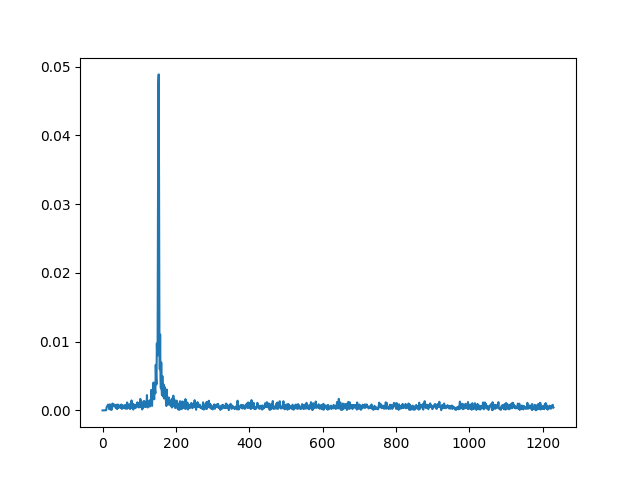

1.0


In [32]:
i = 4000
plt.plot(abs(np.fft.rfft(train_signal[i]) * dt /ASD))
plt.show()
print(train_label[i])

<IPython.core.display.Javascript object>


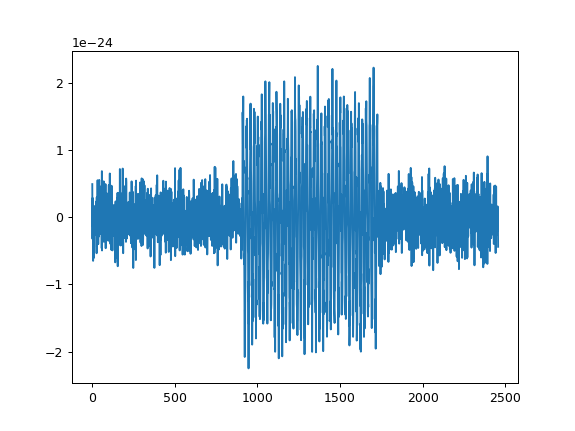

In [101]:
plt.plot(train_signal[i][0][0])
plt.show()

In [56]:
# load the best model
model.load_weights('{0}/best_weights.hdf5'.format(outdir))
# evaluate
eval_results = model.evaluate(test_signal, test_label,
                              sample_weight=None,
                              batch_size=batch_size, verbose=1)
print('Test loss:', eval_results[0])
print('Test accuracy:', eval_results[1])


10000/10000 [==============================] - 1s 143us/step
('Test loss:', 0.6934680640697479)
('Test accuracy:', 0.5)


In [57]:
test_preds = model.predict(test_signal)


In [169]:
model = Sequential()    # define the type of keras model

# add the layers
# conv1
model.add(Dense(40, activation ='sigmoid', input_shape=input_shape))
# add the output layer with softmax actiavtion for classication
model.add(Dense(12, activation ='sigmoid'))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
# print a summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1, 1, 40)          32840     
_________________________________________________________________
dense_11 (Dense)             (None, 1, 1, 12)          492       
_________________________________________________________________
flatten_3 (Flatten)          (None, 12)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 26        
Total params: 33,358
Trainable params: 33,358
Non-trainable params: 0
_________________________________________________________________


In [172]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr = 0.1),
              metrics=['accuracy'])

history = model.fit(train_signal, train_label,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(val_signal, val_label),
                    callbacks = [modelCheck]
                   )


Train on 30 samples, validate on 30 samples
Epoch 1/20
30/30 [==============================] - 0s 9ms/step - loss: 0.6941 - acc: 0.5000 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 2/20
30/30 [==============================] - 0s 267us/step - loss: 0.6994 - acc: 0.5000 - val_loss: 0.6939 - val_acc: 0.5000
Epoch 3/20
30/30 [==============================] - 0s 265us/step - loss: 0.6950 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/20
30/30 [==============================] - 0s 333us/step - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 5/20
30/30 [==============================] - 0s 308us/step - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/20
30/30 [==============================] - 0s 305us/step - loss: 0.6947 - acc: 0.5000 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 7/20
30/30 [==============================] - 0s 367us/step - loss: 0.6994 - acc: 0.5000 - val_loss: 0.6939 - val_acc: 0.5000
Epoch 8/20
30/30 [================

In [ ]:
def gen_noise(fs,T_obs,psd):
    """
    Generates noise from a psd
    """
    np.random.seed(2)
    N = T_obs * fs          # the total number of time samples
    Nf = int(np.ceil(N / 2) + 1)
    dt = 1 / fs             # the sampling time (sec)
    df = 1 / T_obs

    amp = np.sqrt(0.25*T_obs*psd)
    
    idx = np.argwhere(psd==0.0)
    amp[idx] = 0.0
    re = amp*np.random.normal(0,1,Nf)
    im = amp*np.random.normal(0,1,Nf)
    re[0] = 0.0
    im[0] = 0.0
    idx_1 = int(20 // df)
    re[0:idx_1] = 0
    im[0:idx_1] = 0
    x = N*np.fft.irfft(re + 1j*im)*df

    return x

<IPython.core.display.Javascript object>


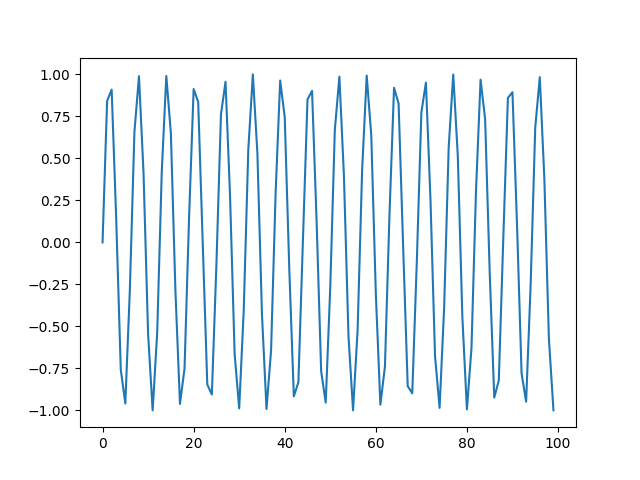

In [171]:
x = np.arange(100)
y = np.sin(x)
plt.plot(x,y)
plt.show()